# Individual Planning Report

## Project: Predicting Newsletter Subscription Based on Player Characteristics

This report proposes a data science project using data from UBC's MineCraft server to investigate whether player data can predict newsletter subscription. 

## 1. Data Description
Two datasets are used from the server: 
- **players.csv**: One row per player, including demographics and subscription status. 
- **sessions.csv**: One row per play-session, with player identifiers (hashed emails) and session start/end times.  


In [2]:
library(tidyverse)

players <- read_csv("Data/players.csv")

head(players, n = 10)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,47


players.csv has **196** observations across **seven** variables:
- **experience (character)**: Five levels indicating playing experience
- **Subscribe (logical)**: Newsletter subscription status
- **hashedEmail (character)**: Encoded player email 
- **played_hours (double)**: Total hours played 
- **name (character)**: Player's name
- **gender (character)**: Player's gender
- **age (double)**: Player's age

Summary Statistics:

In [3]:
players_factor <- players |>
  #Converts non numerical variables to factors so percentages can be calculated
  mutate(experience = factor(experience),
    gender = factor(gender),
    subscribe = factor(subscribe)
        )
#Summarise to calculate summary statistics for age and hours played
age_summary <- players_factor |>
    summarise(mean_age = round(mean(Age, na.rm = TRUE), 2),
              median_age = median(Age, na.rm = TRUE),
              min_age = min(Age, na.rm = TRUE),
              max_age = max(Age, na.rm = TRUE)
              )
age_summary
hours_summary <- players_factor |>
    summarise(mean_played_hours = round(mean(played_hours, na.rm = TRUE), 2),
            median_played_hours = median(played_hours, na.rm = TRUE),
            min_played_hours = min(played_hours, na.rm = TRUE),
            max_played_hours = max(played_hours, na.rm = TRUE)
             )

hours_summary

#Percentages for gender, experience and subscribed
gender_pct <- players_factor |>
  count(gender) |>
  mutate(percentage = round(n / sum(n) * 100, 2))|>
  rename(number = n)

experience_pct <- players_factor |>
  count(experience) |>
  mutate(percentage = round(n / sum(n) * 100, 2))|>
  rename(number = n)

subscribe_pct <- players_factor |>
  count(subscribe) |>
  mutate(percentage = round(n / sum(n) * 100, 2))|>
  rename(number = n)

gender_pct
experience_pct
subscribe_pct

mean_age,median_age,min_age,max_age
<dbl>,<dbl>,<dbl>,<dbl>
21.14,19,9,58


mean_played_hours,median_played_hours,min_played_hours,max_played_hours
<dbl>,<dbl>,<dbl>,<dbl>
5.85,0.1,0,223.1


gender,number,percentage
<fct>,<int>,<dbl>
Agender,2,1.02
Female,37,18.88
Male,124,63.27
Non-binary,15,7.65
Other,1,0.51
Prefer not to say,11,5.61
Two-Spirited,6,3.06


experience,number,percentage
<fct>,<int>,<dbl>
Amateur,63,32.14
Beginner,35,17.86
Pro,14,7.14
Regular,36,18.37
Veteran,48,24.49


subscribe,number,percentage
<fct>,<int>,<dbl>
FALSE,52,26.53
TRUE,144,73.47


sessions.csv:



In [4]:
sessions <- read_csv("Data/sessions.csv")

head(n = 10,sessions)

#Information on Unix time taken from here:
#https://unixtime.io/what-is-unix-time

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,15/04/2024 07:12,15/04/2024 07:21,1.71317e+12,1.71317e+12
ad6390295640af1ed0e45ffc58a53b2d9074b0eea694b16210addd44d7c81f83,21/09/2024 02:13,21/09/2024 02:30,1.72688e+12,1.72689e+12
96e190b0bf3923cd8d349eee467c09d1130af143335779251492eb4c2c058a5f,21/06/2024 02:31,21/06/2024 02:49,1.71894e+12,1.71894e+12


There are **1535** observations and **5** variables for sessions.csv dataset.
- **hashedEmail (character)**: Encoded player email
- **start_time (character)**: Date (dd/mm/yy) and time (hh/mm) the session was started 
- **end_time (character)**: Date (dd/mm/yy) and time (hh/mm) the session was ended 
- **original_start_time (double)**: Milliseconds since January 1st, 1970 to when the session was started 
- **original_end_time (double)**: Milliseconds since January 1st, 1970 to when the session was ended 

Summary Statistics:

In [5]:
library(lubridate)

#advice on how to convert using lubridate taken from here:
#https://www.r-bloggers.com/2024/09/mastering-date-and-time-data-in-r-with-lubridate/
sessions_summary <- sessions |>
  mutate(
    start_time = dmy_hm(start_time),
    end_time = dmy_hm(end_time),
    session_minutes = as.numeric(end_time - start_time)
  )|>
summarise(
    mean_minutes = round(mean(session_minutes, na.rm = TRUE), 2),
    median_minutes = round(median(session_minutes, na.rm = TRUE), 2),
    min_minutes = round(min(session_minutes, na.rm = TRUE ), 2),
    max_minutes = round(max(session_minutes, na.rm = TRUE ), 2)
    )

sessions_summary


mean_minutes,median_minutes,min_minutes,max_minutes
<dbl>,<dbl>,<dbl>,<dbl>
50.86,30,3,259


**Limitations**

Both datasets contain missing values, so imputation may be needed. Additionally, findings may be biased as the majority of respondents are quite young. Despite these limitations, the data should still reveal important patterns related to newsletter subscription. 

## 2. Questions
Broad Question: **"What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?"**

Specific Question: **"Can age and hours played predict whether a player will subscribe to a gaming newsletter?"**

Analysis will use the players.csv dataset, which includes all necessary modelling variables. Basic wrangling will involve selecting relevant columns and handling missing values.  A classification model will then be built to predict subscription status, using centering and scaling to ensure standardized predictor distances. 

## 3. Exploratory Data Analysis and Visualization

Summary statistics were previously calculated, and minimum wrangling (accounting for N/A’s, factor conversion) was performed. Three visualizations below explore potential trends: age distribution, playtime distribution, and a scatter plot comparing both by subscription status. 

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


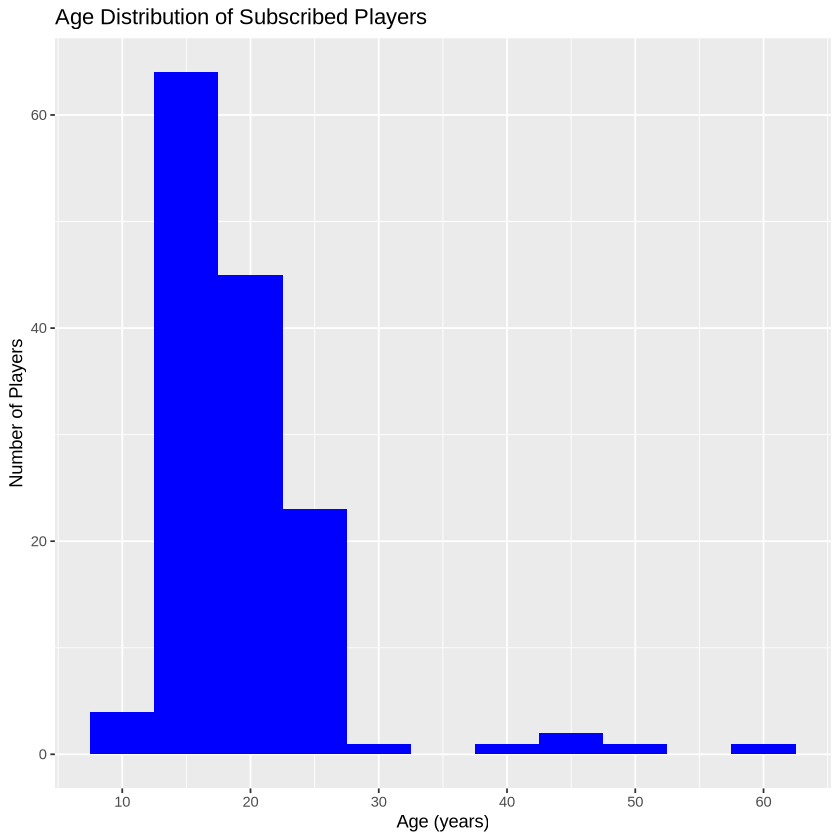

In [6]:
players_yes_factor <- players_factor |>
    filter(subscribe == "TRUE")

players_yes_plot <- ggplot(players_yes_factor, aes(x = Age)) +
  geom_histogram(fill = "Blue", 
                 binwidth = 5) +
  scale_x_continuous(n.breaks = 10)+
  labs(title = "Age Distribution of Subscribed Players",
       x = "Age (years)",
       y = "Number of Players") 
  
players_yes_plot


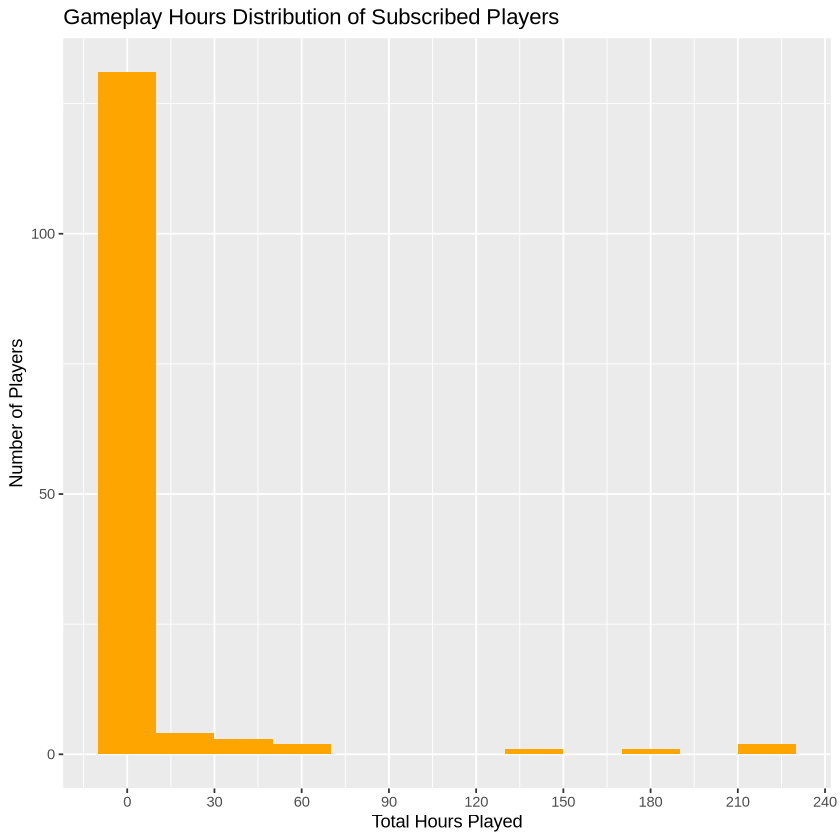

In [7]:
hours_yes_plot <- ggplot(players_yes_factor, aes(x = played_hours)) +
  geom_histogram(fill = "Orange", 
                 binwidth = 20) +
  scale_x_continuous(n.breaks = 10)+
  labs(title = "Gameplay Hours Distribution of Subscribed Players",
       x = "Total Hours Played",
       y = "Number of Players")
  
hours_yes_plot

Warning message:
“Removed 11 rows containing missing values or values outside the scale range
(`geom_point()`).”


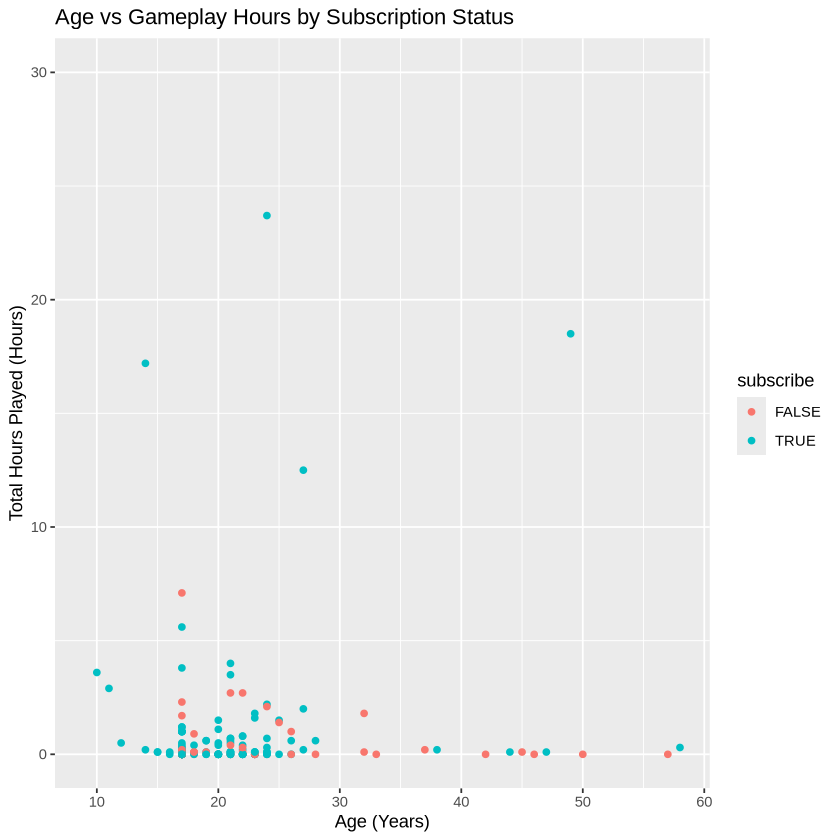

In [8]:
hours_age_plot <- players_factor|>
    ggplot(aes(x = Age, y = played_hours, color = subscribe))+
    geom_point()+
    labs(title = "Age vs Gameplay Hours by Subscription Status", x = "Age (Years)", y = "Total Hours Played (Hours)")+
    ylim(0,30)

hours_age_plot

These visualizations reveal several patterns. Most subscribers were **quite young**, consistent with the university-based sample. Additionally, most subscribers had **low playtime**, likely due to busy schedules. The scatter plot showed little relationship between age and playtime, however most players did subscribe. Overall, no strong patterns could link the variables, however further analysis is needed to confirm that this question cannot be reliably answered.  

## 4. Methods and Plan

A KNN classification model will predict newsletter subscription due to its strengths with categorical data and its minimum assumptions needed. One limitation is the unevenness between subscription status, but upsampling will be used to balance the dataset. The data will then be split into 80% training and 20% testing sets, before cross-validation selects the optimal K value, being used in the final predictive model. 

## 5. Conclusion

In conclusion, this outlines the first findings of the project, however more work must be done to come to conclusions about the question asked.  